# MRAugmenter 개별 증강 기능 검증 노트북

이 노트북은 `mraugmenter.py`에 구현된 각 증강(Augmentation) 함수들이 의도대로 정확하게 동작하는지 시각적으로 확인하는 것을 목표로 합니다.

**사전 준비:**
1. 이 노트북 파일과 `mraugmenter.py` 파일을 같은 디렉토리에 위치시켜 주세요.
2. 아래 `DATA_PATH` 변수에 실제 k-space 데이터 파일의 경로를 정확하게 입력해주세요.

In [4]:
import os
import sys
import h5py
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import display, Markdown

# --- 사용자 설정 ---
# 1. mraugmenter.py 파일이 있는 경로 설정 (노트북과 같은 경로에 있다면 '.'으로 두면 됩니다)
MRAUGMENTER_DIR = '.'
# 2. 검증에 사용할 h5 파일 경로 설정
DATA_PATH = '/Users/sinjeongmin/Desktop/25-3/박상원/data1/val/kspace/brain_acc4_100.h5'
# 3. 파일에서 읽어올 슬라이스 인덱스 설정
SLICE_INDEX = 9

# mraugmenter.py를 임포트하기 위해 경로 추가
sys.path.append(os.path.abspath(MRAUGMENTER_DIR))
from mraugmenter import MRAugmenter

# Matplotlib 기본 설정
plt.rcParams['figure.figsize'] = [12, 5]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10
plt.rcParams['image.cmap'] = 'gray'

## 1. MRAugmenter 인스턴스 및 헬퍼 함수 정의

In [27]:
# 검증을 위한 Augmenter 파라미터 설정
# 각 변환을 독립적으로 테스트하기 위해 스케줄링은 끄고(constant), 확률은 최대로(1.0) 설정합니다.
params = {
    'aug_on': True,
    'aug_strength': 1.0,  # 확률을 1.0으로 고정하여 항상 적용되도록 함
    'aug_schedule_mode': 'constant',
    'aug_schedule_type': 'ramp',
    'aug_delay': 0,
    'max_epochs': 100,
    'aug_exp_decay': 4.0,
    'val_loss_window_size': 10,
    'val_loss_grad_start': -1e-4,
    'val_loss_grad_plateau': -1e-6,
    # 모든 증강의 가중치를 1로 설정하여 _random_apply가 항상 True를 반환하도록 함
    'weight_dict': {
        'fliph': 1.0, 'flipv': 1.0, 'rotate': 1.0, 
        'scale': 1.0, 'shift': 1.0, 'shear': 1.0
    },
    'max_rotation_angle': 90.0,
    'scale_range': (1.5, 2.0),
    'shift_extent': 30.0, # 픽셀 단위 표준편차
    'max_shear_angle': 10.0 # 도(degree) 단위
}

augmenter = MRAugmenter(**params)
print("MRAugmenter 인스턴스 생성 완료.")

# --- 헬퍼 함수 정의 ---

def kspace_to_image(kspace_tensor):
    """k-space 텐서를 이미지 공간 텐서로 변환합니다."""
    kspace_unshifted = torch.fft.ifftshift(kspace_tensor, dim=(-2, -1))
    image_domain = torch.fft.ifft2(kspace_unshifted, norm='ortho')
    return torch.fft.fftshift(image_domain, dim=(-2, -1))

def show_comparison(original_img, augmented_img, title):
    """원본 이미지와 증강된 이미지를 나란히 표시합니다."""
    # 복소수 텐서의 절대값을 취해 실수 이미지로 변환
    if torch.is_complex(original_img):
        original_img = augmenter._rss(original_img).abs()
    if torch.is_complex(augmented_img):
        augmented_img = augmenter._rss(augmented_img).abs()
    
    fig, axes = plt.subplots(1, 2)
    axes[0].imshow(original_img.numpy())
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(augmented_img.numpy())
    axes[1].set_title(f'Augmented: {title}')
    axes[1].axis('off')
    
    plt.suptitle(f'--- {title} Verification ---', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

MRAugmenter 인스턴스 생성 완료.


## 2. 데이터 로드 및 전처리

지정한 경로의 `.h5` 파일에서 k-space 데이터를 로드하고, 이미지로 변환하여 테스트 준비를 합니다.

데이터 로드 성공: brain_acc4_100.h5
선택된 슬라이스: 9
텐서 형태: torch.Size([16, 768, 396]), 타입: torch.complex64


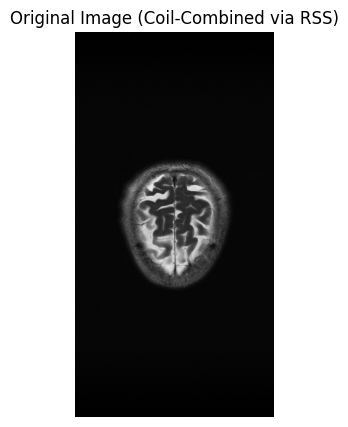

In [28]:
try:
    with h5py.File(DATA_PATH, 'r') as hf:
        # (slice, coil, H, W) 형태의 데이터에서 특정 슬라이스 선택
        kspace_slice_np = hf['kspace'][SLICE_INDEX]
        
    # Numpy 배열을 복소수 PyTorch 텐서로 변환
    # MRAugmenter는 (C, H, W) 형태의 복소수 텐서를 입력으로 기대함
    kspace_tensor = torch.from_numpy(kspace_slice_np).cfloat()
    
    # k-space를 이미지 공간으로 변환 (이것이 모든 증강의 원본이 됨)
    original_image_tensor = kspace_to_image(kspace_tensor)
    
    print(f"데이터 로드 성공: {os.path.basename(DATA_PATH)}")
    print(f"선택된 슬라이스: {SLICE_INDEX}")
    print(f"텐서 형태: {original_image_tensor.shape}, 타입: {original_image_tensor.dtype}")
    
    # 원본 이미지 시각화 (RSS: Root Sum of Squares)
    plt.imshow(augmenter._rss(original_image_tensor).abs().numpy())
    plt.title('Original Image (Coil-Combined via RSS)')
    plt.axis('off')
    plt.show()

except FileNotFoundError:
    print(f"[오류] 파일을 찾을 수 없습니다: {DATA_PATH}")
    print("노트북 상단의 DATA_PATH 변수를 올바른 경로로 수정해주세요.")
except Exception as e:
    print(f"[오류] 데이터 로드 중 문제가 발생했습니다: {e}")

## 3. 개별 증강 함수 테스트

이제 각 증강 함수(`_transform_*`)를 개별적으로 호출하여 원본 이미지와 비교합니다.

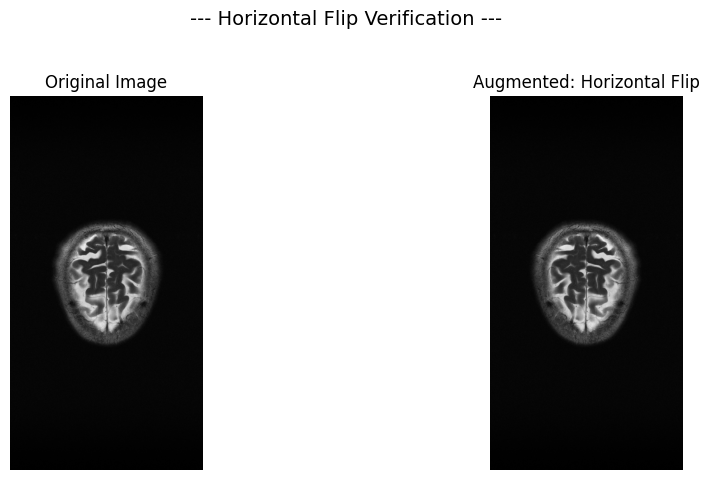

In [22]:
# 1. Horizontal Flip (좌우 반전)
aug_hflip = augmenter._transform_hflip(original_image_tensor.clone()) # 원본 보존을 위해 clone() 사용
show_comparison(original_image_tensor, aug_hflip, 'Horizontal Flip')

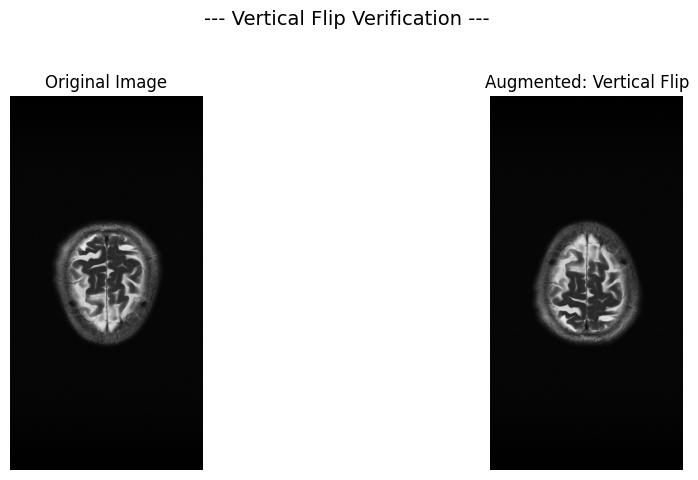

In [23]:
# 2. Vertical Flip (상하 반전)
aug_vflip = augmenter._transform_vflip(original_image_tensor.clone())
show_comparison(original_image_tensor, aug_vflip, 'Vertical Flip')

* 최대 회전 각도: `+/-90.0°`

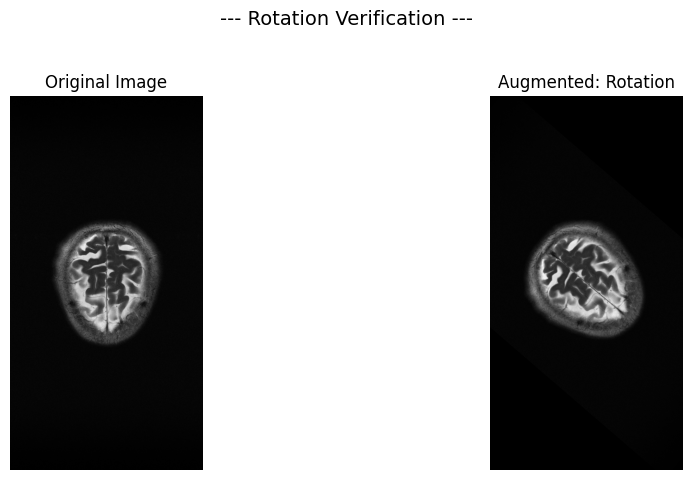

In [24]:
# 3. Rotation (회전)
# augmenter에 설정된 max_rotation_angle 내에서 랜덤 각도로 회전
display(Markdown(f"* 최대 회전 각도: `+/-{augmenter.max_rotation_angle}°`"))
aug_rotate = augmenter._transform_rotate(original_image_tensor.clone())
show_comparison(original_image_tensor, aug_rotate, 'Rotation')

* 스케일 범위: `(1.5, 2.0)`

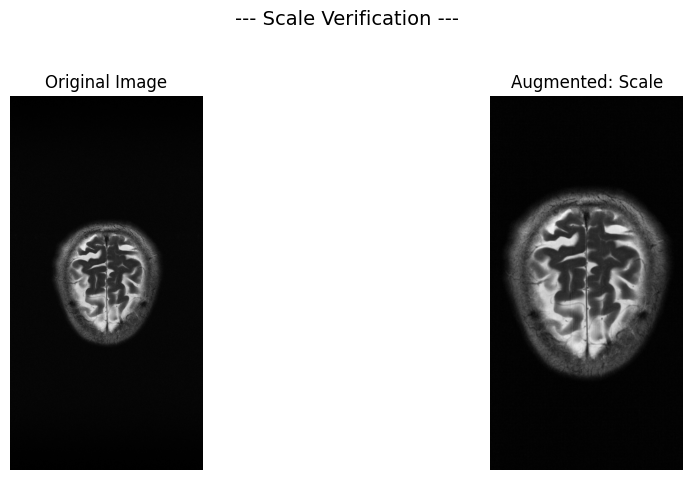

In [25]:
# 4. Scale (확대/축소)
# augmenter에 설정된 scale_range 내에서 랜덤 비율로 크기 조절 후 중앙 크롭
display(Markdown(f"* 스케일 범위: `{augmenter.scale_range}`"))
aug_scale = augmenter._transform_scale(original_image_tensor.clone())
show_comparison(original_image_tensor, aug_scale, 'Scale')

* 이동 강도(표준편차): `30.0` 픽셀

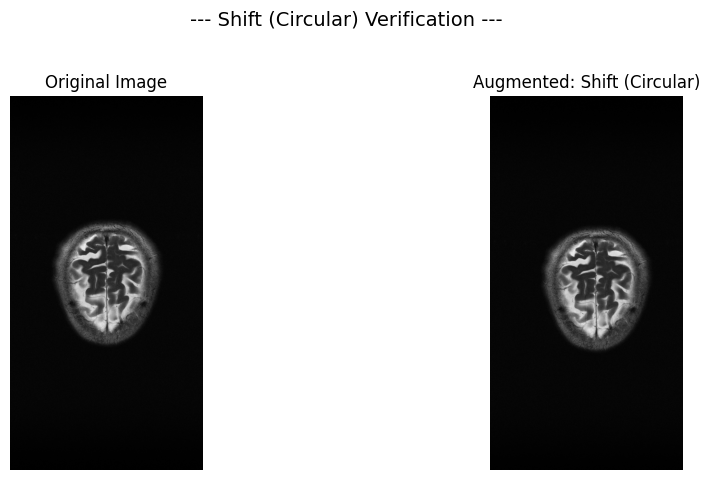

In [29]:
# 5. Shift (이동)
# 이미지 경계를 순환하며 이동 (보간 없음)
display(Markdown(f"* 이동 강도(표준편차): `{augmenter.shift_extent}` 픽셀"))
aug_shift = augmenter._transform_shift(original_image_tensor.clone())
show_comparison(original_image_tensor, aug_shift, 'Shift (Circular)')

* 최대 전단 각도: `+/-10.0°`

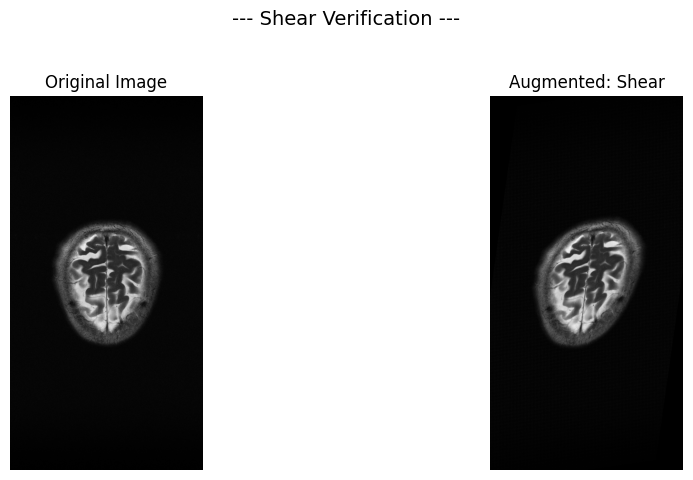

In [30]:
# 6. Shear (전단 변환)
# 이미지를 평행사변형 형태로 기울임
display(Markdown(f"* 최대 전단 각도: `+/-{augmenter.max_shear_angle}°`"))
aug_shear = augmenter._transform_shear(original_image_tensor.clone())
show_comparison(original_image_tensor, aug_shear, 'Shear')